In [189]:
# import the libraries we will use
import numpy as np               # for array and matrix maths
import pandas as pd              # for working with tables of data
import matplotlib.pyplot as plt  # for making plots

In [208]:
# Load the Kaggle german credit data: https://www.kaggle.com/uciml/german-credit/data
df_kaggle = pd.read_csv("~/data/german/german_credit_data.csv", index_col=0)
# Load the original UCI german credit data: https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
df_uci = pd.read_csv("~/data/german/german.data", header=None, sep="\s+")

# Add the last column from the UCI data to the kaggle data to get labels
last_column_uci = df_uci.iloc[:, -1]
df = df_kaggle.assign(Good=last_column_uci)

In [239]:
category_cols = ['Sex', 'Job', 'Housing', 'Purpose']
target_col = 'Good'

for c in category_cols + [target_col]:
    df[c] = df[c].astype('category')

def uci_class_as_boolean(x):
    if x == 1:
        return True
    elif x == 2:
        return False
    else:
        return x
    
df[target_col] = df[target_col].apply(uci_class_as_boolean)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Good
0,67,male,2,own,NaN,little,1169,6,radio/TV,True
1,22,female,2,own,little,moderate,5951,48,radio/TV,False
2,49,male,1,own,little,NaN,2096,12,education,True
3,45,male,2,free,little,little,7882,42,furniture/equipment,True
4,53,male,2,free,little,little,4870,24,car,False
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,True
996,40,male,3,own,little,little,3857,30,car,True
997,38,male,2,own,little,NaN,804,12,radio/TV,True
998,23,male,2,free,little,little,1845,45,radio/TV,False


In [240]:
simple_cols = ['Job', 'Housing']

df_dummy = pd.get_dummies(df[simple_cols])
female_s = (df['Sex'] == 'female')
female_s = female_s.astype(np.uint8)
female_s.name = 'Female'

df_train = pd.concat([female_s, df_dummy], axis=1)
df_train

,Female,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent
0,0,0,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,0,0,1,0,0,0,1,0
3,0,0,0,1,0,1,0,0
4,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
995,1,0,1,0,0,0,1,0
996,0,0,0,0,1,0,1,0
997,0,0,0,1,0,0,1,0
998,0,0,0,1,0,1,0,0


In [214]:
X = pd.get_dummies(df_train).values
y = df[target_col].cat.codes.values

In [215]:
import pystan

In [46]:
model_code = """
data {
    int<lower=0> N;
    int<lower=1> D;

    int<lower=0, upper=1> y[N];
    matrix[N,D] x;
    
    real<lower=0> beta_prior_std;
    real<lower=0> alpha_prior_std;
}

parameters {
    vector[D] beta;
    real alpha;
}

model {
    beta ~ normal(0, beta_prior_std);
    alpha ~ normal(0, alpha_prior_std);

    y ~ bernoulli_logit(x * beta + alpha);
}
"""

In [7]:
logit_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96c1883fed5d7ffc7a6170934fd5d0bf NOW.


In [8]:
data = dict(
    N=X.shape[0],
    D=X.shape[1],
    x=X, y=y,
    beta_prior_std=1.0,
    alpha_prior_std=1.0)

logit_fit = logit_model.sampling(data=data)

In [9]:
samples = logit_fit.extract()

In [29]:
logit_fit

Inference for Stan model: anon_model_96c1883fed5d7ffc7a6170934fd5d0bf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]  -0.12    0.01   0.56  -1.23   -0.5  -0.13   0.27   0.95   1603    1.0
beta[2]  -0.18    0.01   0.48  -1.11  -0.51  -0.19   0.15   0.79   1275    1.0
beta[3]  -0.14    0.01   0.47  -1.06  -0.46  -0.14   0.17   0.78   1234    1.0
beta[4]   0.03    0.01   0.48  -0.92   -0.3   0.04   0.36   0.97   1298    1.0
beta[5]   0.08    0.02   0.53  -0.95  -0.27   0.08   0.44   1.16   1184    1.0
beta[6]  -0.54    0.02   0.52  -1.54  -0.88  -0.54   -0.2    0.5   1127    1.0
beta[7]   0.06    0.02   0.52  -0.92  -0.29   0.06   0.39   1.11   1135    1.0
alpha    -0.38    0.02    0.6  -1.52  -0.79  -0.39   0.02    0.8   1193    1.0
lp__    -605.7    0.05    2.0 -610.3 -606.9 -605.4 -604.3 -602.9   1390    1.0

Samples were drawn u

In [10]:
beta_samples = samples['beta']
for i in range(beta_samples.shape[1]):
    column_name = df_train.columns[i]
    mean = beta_samples[:,i].mean()
    std = beta_samples[:,i].std()
    print("{}: {:.2f} ({:.2f})".format(column_name, mean, std))

Female: -0.30 (0.15)
Job_0: 0.18 (0.56)
Job_1: 0.19 (0.49)
Job_2: 0.15 (0.48)
Job_3: -0.04 (0.49)
Housing_free: -0.11 (0.54)
Housing_own: 0.55 (0.53)
Housing_rent: 0.02 (0.54)


In [11]:
model_code = """
data {
    int<lower=0> N;
    int<lower=1> D;

    int<lower=0, upper=1> y[N];
    matrix[N,D] x;
    
    real<lower=0> u_prior_std;
    real<lower=0> beta_prior_std;
    real<lower=0> alpha_prior_std;
}

parameters {
    vector[D] beta;
    vector[N] u;
    real alpha;
}

model {
    u ~ normal(0, u_prior_std);
    beta ~ normal(0, beta_prior_std);
    alpha ~ normal(0, alpha_prior_std);

    y ~ bernoulli_logit(x * beta + u + alpha);
}
"""

In [12]:
u_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3f431799989aa1f6f24df44d83f9f39 NOW.


In [14]:
data = dict(
    N=X.shape[0],
    D=X.shape[1],
    x=X, y=y,
    u_prior_std=1.0,
    beta_prior_std=1.0,
    alpha_prior_std=1.0)

u_fit = u_model.sampling(data=data, control=dict(max_treedepth=15))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
# pystan.check_hmc_diagnostics(u_fit)

In [17]:
samples = u_fit.extract()

(array([171., 114.,  15.,   0.,   0.,   0.,   0., 125., 462., 113.]),
 array([-0.68427657, -0.57357949, -0.4628824 , -0.35218532, -0.24148824,
        -0.13079116, -0.02009408,  0.09060301,  0.20130009,  0.31199717,
         0.42269425]),
 <a list of 10 Patch objects>)

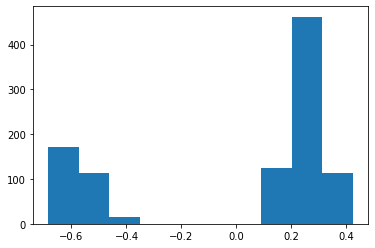

In [18]:
plt.hist(samples['u'].mean(axis=0))

In [19]:
beta_samples = samples['beta']
for i in range(beta_samples.shape[1]):
    column_name = df_train.columns[i]
    mean = beta_samples[:,i].mean()
    std = beta_samples[:,i].std()
    print("{}: {:.2f} ({:.2f})".format(column_name, mean, std))

Female: -0.35 (0.18)
Job_0: 0.20 (0.61)
Job_1: 0.23 (0.50)
Job_2: 0.18 (0.48)
Job_3: -0.04 (0.50)
Housing_free: -0.14 (0.55)
Housing_own: 0.64 (0.54)
Housing_rent: 0.01 (0.55)


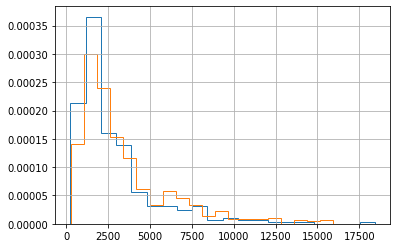

In [20]:
fig, ax = plt.subplots()

df['Credit amount'][df['Sex'] == 'female'].hist(ax=ax, histtype='step', density=True, bins=20)
df['Credit amount'][df['Sex'] == 'male'].hist(ax=ax, histtype='step', density=True, bins=20)

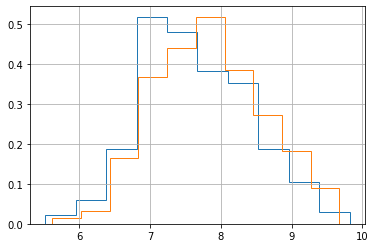

In [21]:
fig, ax = plt.subplots()

df['Credit amount'][df['Sex'] == 'female'].apply(np.log).hist(ax=ax, histtype='step', density=True)
df['Credit amount'][df['Sex'] == 'male'].apply(np.log).hist(ax=ax, histtype='step', density=True)

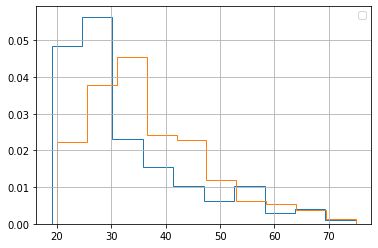

In [216]:
fig, ax = plt.subplots()

df['Age'][df['Sex'] == 'female'].hist(ax=ax, histtype='step', density=True)
df['Age'][df['Sex'] == 'male'].hist(ax=ax, histtype='step', density=True)

ax.legend()

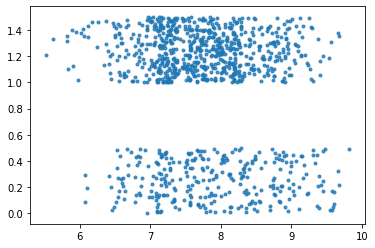

In [35]:
fig, ax = plt.subplots()

x = np.log(df['Credit amount'].values)
y = df[target_col].cat.codes
y = y + 0.5*np.random.rand(len(y))

ax.scatter(x, y, marker='.', alpha=0.8)

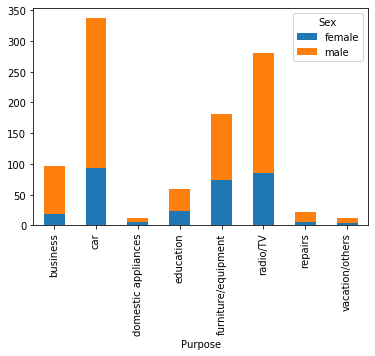

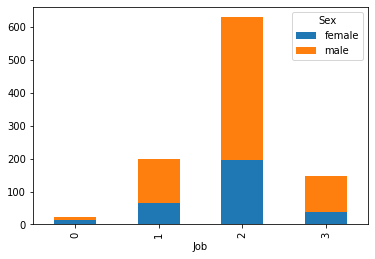

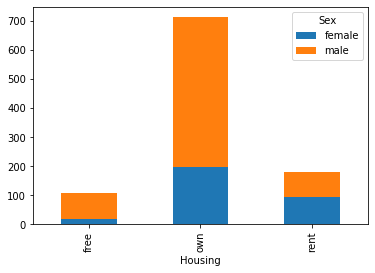

In [36]:
for c in ['Purpose', 'Job', 'Housing']:
    df[['Sex', c]].groupby(['Sex', c]).size().unstack(level=0).plot(kind='bar', stacked=True)

In [37]:
d = df[['Sex', 'Job']].groupby(['Sex', 'Job']).size().unstack(level=0)
# d.div(d.sum(axis=1), axis=0) # proportion of category
d.div(d.sum(axis=0), axis=1) # relative rate

Sex,female,male
Job,,
0,0.038710,0.014493
1,0.206452,0.197101
2,0.635484,0.627536
3,0.119355,0.160870


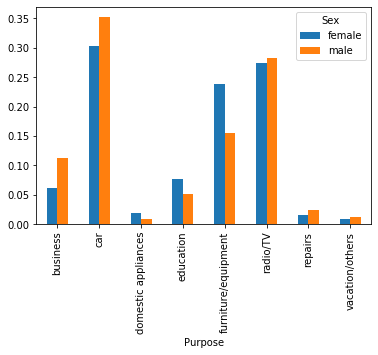

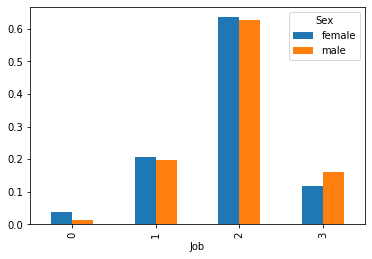

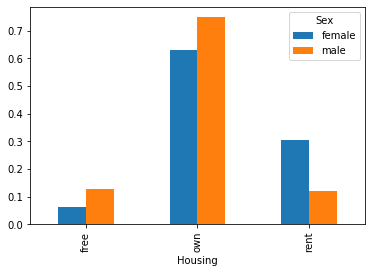

In [38]:
for c in ['Purpose', 'Job', 'Housing']:
    d = df[['Sex', c]].groupby(['Sex', c]).size().unstack(level=0)
    d = d.div(d.sum(axis=0), axis=1)
    d.plot(kind='bar')

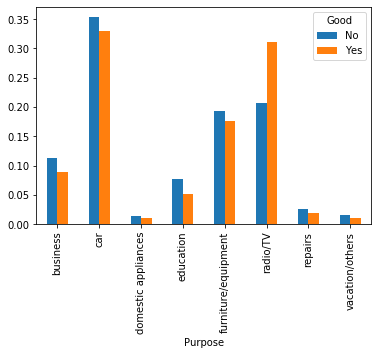

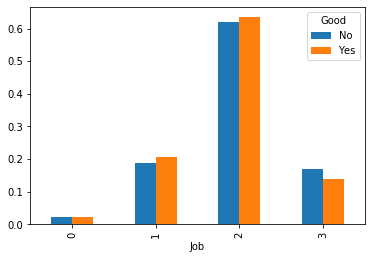

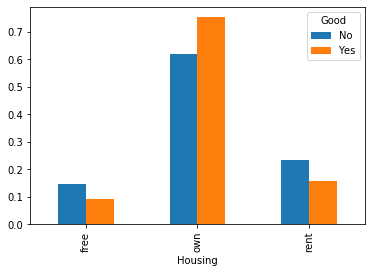

In [40]:
for c in ['Purpose', 'Job', 'Housing']:
    d = df[[target_col, c]].groupby([target_colget_col, c]).size().unstack(level=0)
    d = d.div(d.sum(axis=0), axis=1)
    d.plot(kind='bar')

In [237]:
model_code = """
data {
    int<lower=0> N;

    int<lower=1> K_job;
    int<lower=1> K_housing;
    int<lower=2> K_purpose;

    vector[N] female;

    int job[N];
    int housing[N];
    int purpose[N];
    
    real<lower=0> u_prior_std;
    real<lower=0> alpha_prior_std;
    real<lower=0> beta_prior_std;
}

parameters {
    vector[K_job]     job_alpha;
    vector[K_housing] housing_alpha;
    vector[K_purpose] purpose_alpha;

    vector[K_job]     job_beta;
    vector[K_housing] housing_beta;
    vector[K_purpose] purpose_beta;

    vector[K_job]     job_u_beta;
    vector[K_housing] housing_u_beta;
    vector[K_purpose] purpose_u_beta;

    vector[N] u;
}

model {
    u ~ normal(0, u_prior_std);

    job_alpha      ~ normal(0, alpha_prior_std);
    housing_alpha  ~ normal(0, alpha_prior_std);
    purpose_alpha  ~ normal(0, alpha_prior_std);

    job_beta       ~ normal(0, beta_prior_std);
    housing_beta   ~ normal(0, beta_prior_std);
    purpose_beta   ~ normal(0, beta_prior_std);

    job_u_beta     ~ normal(0, beta_prior_std);
    housing_u_beta ~ normal(0, beta_prior_std);
    purpose_u_beta ~ normal(0, beta_prior_std);

    for (n in 1:N) {
        job[n]     ~ categorical_logit(female[n]*job_beta     + job_alpha     + u[n]*job_u_beta);
        housing[n] ~ categorical_logit(female[n]*housing_beta + housing_alpha + u[n]*housing_u_beta);
        purpose[n] ~ categorical_logit(female[n]*purpose_beta + purpose_alpha + u[n]*purpose_u_beta);
    }
}
"""

In [238]:
cf_model1 = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a8a6f9de89012fa60c6bc994e623a15a NOW.


In [242]:
data = dict(
    u_prior_std=1.0,
    alpha_prior_std=1.0,
    beta_prior_std=1.0,
    N=len(df),
    female=(df['Sex'] == 'female').astype(np.uint8).values,
    job=df['Job'].cat.codes.values + 1,
    housing=df['Housing'].cat.codes.values + 1,
    purpose=df['Purpose'].cat.codes.values + 1,
    K_job=df['Job'].cat.categories.size,
    K_housing=df['Housing'].cat.categories.size,
    K_purpose=df['Purpose'].cat.categories.size)

cf_model1_fit = cf_model1.sampling(data=data, iter=400, chains=6, control=dict(max_treedepth=15))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [244]:
print(cf_model1_fit)

Inference for Stan model: anon_model_a8a6f9de89012fa60c6bc994e623a15a.
6 chains, each with iter=400; warmup=200; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=1200.

                     mean se_mean     sd   2.5%    25%     50%     75%   97.5%  n_eff   Rhat
job_alpha[1]        -2.18    0.02   0.57  -3.32  -2.54   -2.14   -1.79   -1.15    959    1.0
job_alpha[2]         0.49    0.02   0.51  -0.46   0.15    0.48    0.85    1.48    782    1.0
job_alpha[3]         1.66    0.02    0.5   0.68    1.3    1.65     2.0    2.63    833    1.0
job_alpha[4]      -5.1e-3    0.02   0.52   -1.0  -0.36 -7.9e-3    0.36     1.0    610    1.0
housing_alpha[1]    -0.96    0.02    0.6  -2.13  -1.38   -0.96   -0.56    0.24    807    1.0
housing_alpha[2]     1.42    0.02   0.57   0.33   1.03    1.41    1.81    2.54   1005    1.0
housing_alpha[3]    -0.38    0.02   0.58  -1.47  -0.78   -0.38    0.02    0.77    975    1.0
purpose_alpha[1]     0.71    0.02   0.38  -0.06   0.46    0.72    0.96

In [245]:
samples = cf_model1_fit.extract()

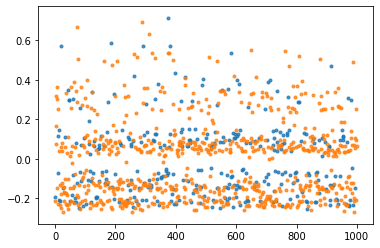

In [246]:
pc = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
f = (df['Sex'] == 'female').values
m = (df['Sex'] == 'male').values
u_samples = samples['u']
idx = np.arange(u_samples.shape[1])

plt.scatter(idx[f], u_samples[:,f].mean(axis=0), marker='.', alpha=0.8)
plt.scatter(idx[m], u_samples[:,m].mean(axis=0), marker='.', alpha=0.8)